In [13]:
from sklearnex import patch_sklearn
patch_sklearn()

import os
os.chdir("..")

import random
from tqdm import tqdm
from pathlib import Path
import numpy as np
import cv2
from joblib import Parallel, delayed, parallel_backend
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from multiprocessing import Pool
from sklearn.model_selection import cross_validate
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator

from skin_lesion_cad.data.BOVW import DenseDescriptor, BagofWords, ColorDescriptor
from skin_lesion_cad.features.colour import ColorFeaturesDescriptor

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline

import seaborn as sns


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from skin_lesion_cad.features.shape import shape_features

Features

1. ~~Presence of lesions in the mask~~ (useless)
2. Number of lesions in the mask
3. Mean and std of their areas
4. Select the largest lesion and compute its
   * area
   * perimeter
   * circularity
   * eccentricity
   * orientation
   * compactness index, rectangularity, bulkiness, major and minor axis length, convex hull, comparison with a circle, eccentricity
   * hu moments

Still ToDo:


5. Positioning of a regular grid on top of the lesion and compare the color and texture features of the blocks (e.g., by computing the Euclidean or Kullback-Leibler distance between the feature vectors of the symmetric blocks), in order to obtain a statistical-based characterization (e.g., maximum distance, minimum distance, and standard deviation) of their symmetry


In [3]:
def process_img(img_path):
    mask = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    img_name = img_path.name.split('_')[0]
    imf_fearures = shape_features(mask)
    imf_fearures['name'] = img_name
    return imf_fearures

In [9]:
class ColorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
    def fit(self, X, y=None):
        X[np.isnan(X)] = 0
        X[np.isinf(X)] = 0
        return self.scaler.fit(X)
    def transform(self, X, y=None):
        X[np.isnan(X)] = 0
        X[np.isinf(X)] = 0
        return self.scaler.transform(X)

In [4]:
imgs = list(Path('/media/vzalevskyi/DATA/ProjectsData/skin-lesion-cad/data/processed/chall1/train/').glob('**/*mask*'))
res = []

with Pool(8) as pool:
            for result in tqdm(pool.imap(process_img, imgs), total=len(imgs)):
                res.append(result)

100%|██████████| 15195/15195 [03:18<00:00, 76.43it/s] 


Load just color features

In [5]:
nevus = pd.read_feather('/media/vzalevskyi/DATA/ProjectsData/skin-lesion-cad/data/processed/chall1/train/nevus_color_features_meanshift_redo.feather')
others = pd.read_feather('/media/vzalevskyi/DATA/ProjectsData/skin-lesion-cad/data/processed/chall1/train/others_color_features_meanshift_redo.feather')
d1 = pd.concat([nevus, others]).set_index('name')

Transform shape features to pd.DataFrame

In [6]:
d = pd.DataFrame(res).set_index('name')
X = d.values
y = [1 if 'nev' in i else 0 for i in d.index]

### Pure shape features

test_accuracy     0.692399
train_accuracy    0.695327
dtype: float64


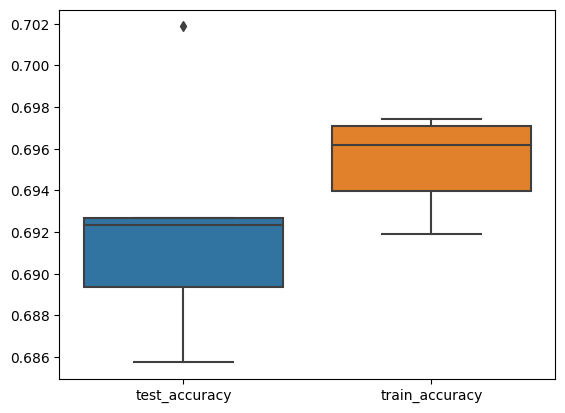

In [26]:
X = d.values
y = [1 if 'nev' in i else 0 for i in d.index]

X[np.isnan(X)] = 0
X[np.isinf(X)] = 0

pipe = Pipeline([('scaler', ColorTransformer()), ('svc', SVC())])

cv_results = cross_validate(pipe, X, y, cv=5, scoring=['accuracy', 'roc_auc'], n_jobs=8, return_train_score=True)
sns.boxplot(pd.DataFrame(cv_results)[['test_accuracy', 'train_accuracy']])
print(pd.DataFrame(cv_results)[['test_accuracy', 'train_accuracy']].mean())

### Shape + Color features

test_accuracy     0.799013
train_accuracy    0.829385
dtype: float64


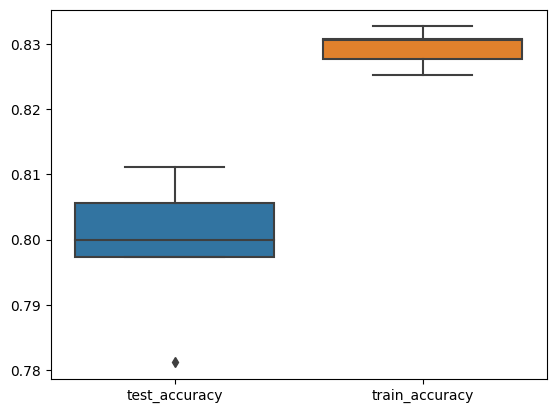

In [29]:
df_merged = d.join(d1)

X = df_merged.values
y = [1 if 'nev' in i else 0 for i in df_merged.index]

pipe = Pipeline([('scaler', ColorTransformer()), ('svc', SVC())])

cv_results_merged = cross_validate(pipe, X, y, cv=5, scoring=['accuracy', 'roc_auc'], n_jobs=8, return_train_score=True)

sns.boxplot(pd.DataFrame(cv_results_merged)[['test_accuracy', 'train_accuracy']])
print(pd.DataFrame(cv_results_merged)[['test_accuracy', 'train_accuracy']].mean())

#### Pure color features

test_accuracy     0.796249
train_accuracy    0.823281
dtype: float64


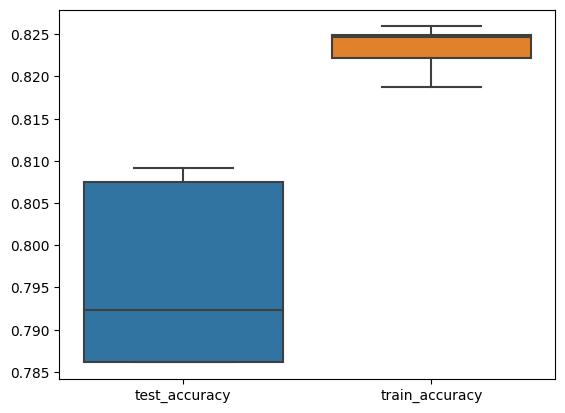

In [30]:
X = d1.values
y = [1 if 'nev' in i else 0 for i in d1.index]

pipe = Pipeline([('scaler', ColorTransformer()), ('svc', SVC())])

cv_results_col = cross_validate(pipe, X, y, cv=5, scoring=['accuracy', 'roc_auc'], n_jobs=8, return_train_score=True)

sns.boxplot(pd.DataFrame(cv_results_col)[['test_accuracy', 'train_accuracy']])
print(pd.DataFrame(cv_results_col)[['test_accuracy', 'train_accuracy']].mean())

In [25]:
# d.reset_index().to_feather('/media/vzalevskyi/DATA/ProjectsData/skin-lesion-cad/data/processed/chall1/train/shape_features.feather')

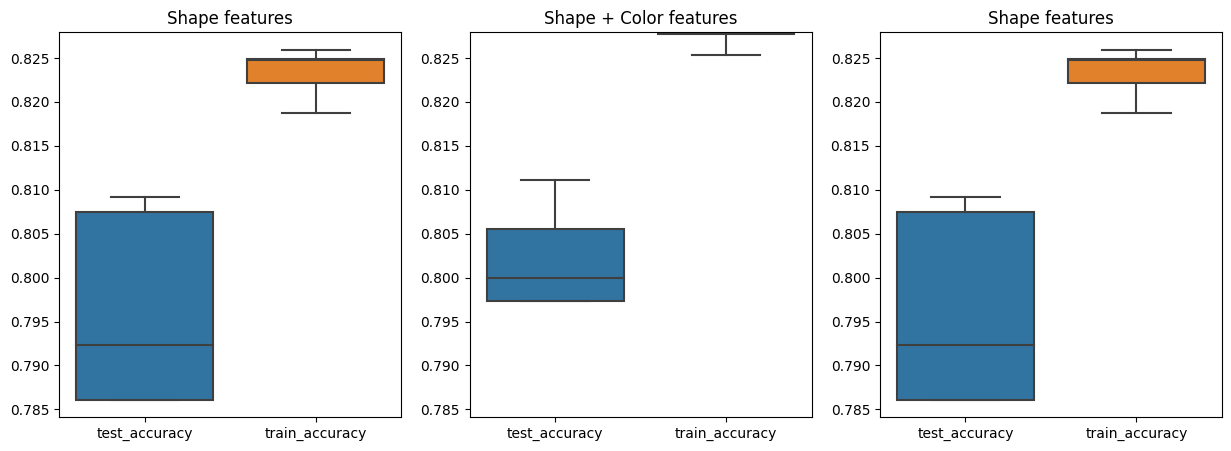

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(pd.DataFrame(cv_results)[['test_accuracy', 'train_accuracy']], ax=axs[0])
axs[0].set_title('Shape features')
sns.boxplot(pd.DataFrame(cv_results_merged)[['test_accuracy', 'train_accuracy']], ax=axs[1])
axs[1].set_title('Shape + Color features')
sns.boxplot(pd.DataFrame(cv_results_col)[['test_accuracy', 'train_accuracy']], ax=axs[2])
axs[2].set_title('Shape features')
axs[1].sharey(axs[0])
axs[2].sharey(axs[1])
